In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from gensim import models, corpora 
from itertools import combinations

import spacy 
import string
import random


# from pyod.models.xgbod import XGBOD
# from sentence_transformers import SentenceTransformer
# conda install pyod 
# conda install xgboost

In [3]:
# to remove stop words 
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
stop_words= list(stop_words) + ['card','I']
def remove_stopwords(text):
    
    # Convert to lowercase
    doc = nlp(text.lower())
    cleaned_words = [
    token.lemma_  # Lemmatization
    for token in doc
    if token.lemma_ not in string.punctuation and token.lemma_ not in stop_words
]

    return " ".join(cleaned_words)

In [4]:
train=pd.read_csv('./task-specific-datasets/banking_data/train.csv')
test=pd.read_csv('./task-specific-datasets/banking_data/test.csv')
data=pd.concat([train,test]).reset_index()
data=data.drop(columns=['index'])


In [5]:
data.describe()

,text,category
count,13083,13083
unique,13083,77
top,I am still waiting on my card?,card_payment_fee_charged
freq,1,227


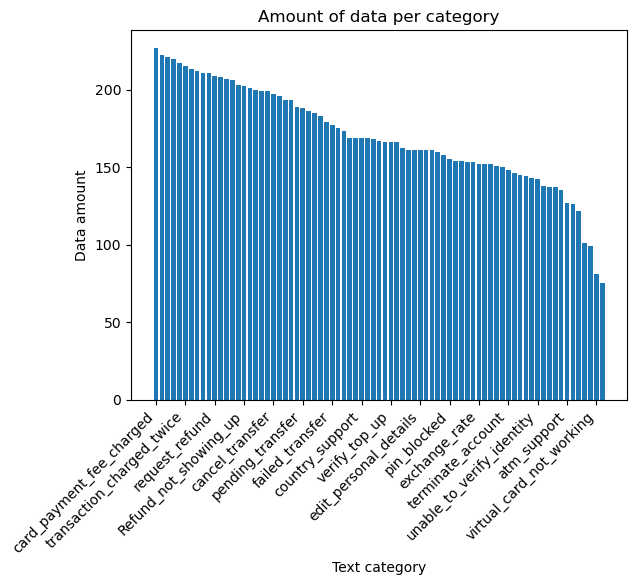

In [6]:

plt.bar(data['category'].value_counts().index ,data['category'].value_counts());
plt.xticks(data['category'].value_counts().index[::5]);
plt.xticks(rotation=45, ha='right');
plt.xlabel('Text category');
plt.ylabel('Data amount');
plt.title('Amount of data per category');


Text(0.5, 1.0, 'char count')

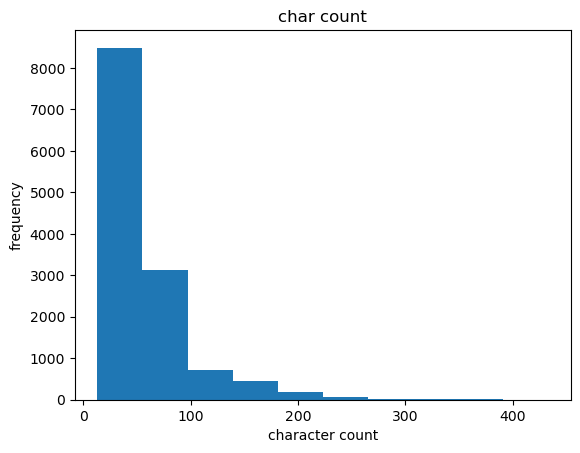

In [7]:
data['char_count'] = data['text'].str.len()
data['word_count'] = data['text'].str.split().str.len()
plt.hist(data['char_count']);
plt.xlabel('character count');
plt.ylabel('frequency');
plt.title('char count')

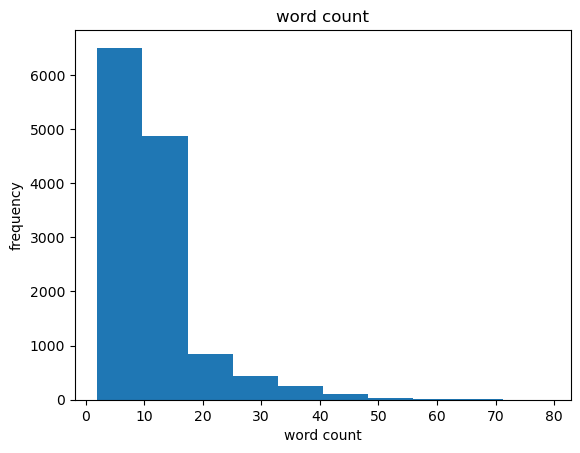

In [8]:
plt.hist(data['word_count']);
plt.xlabel('word count');
plt.ylabel('frequency');
plt.title('word count');

# Performing LDA model to find overall topics in text 

will later use this to define anomalies / non anomaly text 

In [9]:
# Creating bag of word from data
texts = [document.lower().split() for document in data['text'].apply(remove_stopwords)]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [10]:
# Hyperparameter Tuning for Optimal Topics
def find_optimal_topics(min_topics=5, max_topics=25, step=5):
    coherence_values = []
    all_models = []
    
    for num_topics in range(min_topics, max_topics+1, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            alpha='auto',
            eta='auto',
            passes=15
        )
        
        coherence = models.CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        
        coherence_values.append(coherence)
        all_models.append(model)
        print(f"Topics: {num_topics} | Coherence: {coherence:.3f}")
    
    optimal_index = np.argmax(coherence_values)
    return all_models[optimal_index], coherence_values

# best_model, coherence_scores = find_optimal_topics()

In [11]:
best_model, coherence_scores = find_optimal_topics(5,25)

Topics: 5 | Coherence: 0.414
Topics: 10 | Coherence: 0.426
Topics: 15 | Coherence: 0.469
Topics: 20 | Coherence: 0.542
Topics: 25 | Coherence: 0.555


I'm using Coherence score to find the optimal number of topics based on word similarity per topic.
The lower the cohernece score the worse the topic/word realtionship is but the higher the coherence score, the better the words relate per topic.

good breakdown link 
https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4


# Topic Stability to see how stable our topics are when we run LDA over and over 

In [12]:
# Stability Analysis with Jaccard Similarity
def jaccard_similarity(topic1, topic2):
    """Calculate Jaccard similarity between two topics"""
    set1 = set([word for word, _ in topic1])
    set2 = set([word for word, _ in topic2])
    return len(set1 & set2) / len(set1 | set2)

def stability_analysis(lda_model,num_runs=5):
    all_topics = []
    for _ in range(num_runs):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=lda_model.num_topics,
            alpha='auto',  # Automatic asymmetric alpha
            eta='auto',    # Automatic asymmetric eta
            passes=15,
        )
        
        all_topics.append([model.show_topic(tid, topn=10) for tid in range(model.num_topics)]) #getting words and weights that contribute to topic
    
    # Compare topic words across runs
    similarities = []
    for run1, run2 in combinations(all_topics, 2):
        run_sim = [max(jaccard_similarity(t1, t2) for t2 in run2) for t1 in run1]
        similarities.append(np.mean(run_sim))
    
    return np.mean(similarities) # getting average jaccard similarity per run


In [13]:
stability_score = stability_analysis(best_model,num_runs=10)
print(f"Average topic stability across runs: {stability_score:.2f}")

Average topic stability across runs: 0.16


# Questions 

1. Should I design my LDA model for the best coherence score or should i design my model based on the most stable topics?


Im performing Jaccard similarity test becuase I want to see how often I'll get the same topics for each run espically since i get new topics every run.

ranges from 0-1 higher scores means more similarity compared to lower scores 


# Actually getting words for each topic and assigning label

In [14]:

# Get topic distribution for each document
doc_topics = [] # will contain all labels for each dataset
for doc in corpus:
    # Get topic probabilities for document
    topic_probs = best_model.get_document_topics(doc)
    # returns ( label and probability )
    dominant_topic = max(topic_probs, key=lambda x: x[1]) # returns ( label and probability )
    # later use to make labels if topic is good 
    doc_topics.append(dominant_topic[0])

# Getting the actual topics and words assocaited with each topic 

# getting perplexity score
perplexity = best_model.log_perplexity(corpus)
print("Model with 10 topics Perplexity score:", perplexity)

# Getting the actual topics and words assocaited with each topic 
num_words = 10
for topic_id in range(best_model.num_topics):
    # Get top words for the topic
    topic_words = best_model.show_topic(topic_id, num_words)
    # topic_words returns list of (word, probability) tuples
    words = [word for word, prob in topic_words]
    
    print(f'Topic: {topic_id}')
    print('  ' + ', '.join(words))

 

Model with 10 topics Perplexity score: -9.32548683599713
Topic: 0
  fund, come, add, money, different, step, specific, usd, permission, interval
Topic: 1
  transaction, like, look, recognize, reject, double, freeze, provide, strange, hi
Topic: 2
  transfer, bank, right, explain, decline, information, miss, offer, place, assist
Topic: 3
  exchange, currency, rate, wrong, possible, support, foreign, apply, abroad, europe
Topic: 4
  accept, limit, credit, available, set, auto, travel, certain, date, automatically
Topic: 5
  refund, purchase, think, item, soon, recently, wonder, company, possible, recent
Topic: 6
  money, atm, withdraw, machine, early, hello, access, today, remove, notice
Topic: 7
  try, tell, decline, cancel, work, use, online, happen, pound, wrong
Topic: 8
  order, revert, arrive, new, return, stop, unable, overseas, question, united
Topic: 9
  need, verify, know, physical, let, service, mistake, locate, remember, reflect
Topic: 10
  payment, statement, deposit, notice, 

In [15]:
topics_list = []

for topic_id in range(best_model.num_topics):
    topic_words = best_model.show_topic(topic_id, num_words)
    
    # Create a dictionary for the topic
    topic_dict = {'Topic_ID': topic_id}
    
    # Add words and probabilities to the dictionary
    for i, (word, prob) in enumerate(topic_words):
        topic_dict[f'Word_{i+1}'] = word
        # topic_dict[f'Prob_{i+1}'] = prob
    
    topics_list.append(topic_dict)

    topics_df = pd.DataFrame(topics_list)

# Reorder columns for better readability
columns = ['Topic_ID'] + [f'Word_{i+1}' for i in range(num_words)]
topics_df = pd.DataFrame(topics_list)[columns]


In [16]:
topics_df

,Topic_ID,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
0,0,fund,come,add,money,different,step,specific,usd,permission,interval
1,1,transaction,like,look,recognize,reject,double,freeze,provide,strange,hi
2,2,transfer,bank,right,explain,decline,information,miss,offer,place,assist
3,3,exchange,currency,rate,wrong,possible,support,foreign,apply,abroad,europe
4,4,accept,limit,credit,available,set,auto,travel,certain,date,automatically
5,5,refund,purchase,think,item,soon,recently,wonder,company,possible,recent
6,6,money,atm,withdraw,machine,early,hello,access,today,remove,notice
7,7,try,tell,decline,cancel,work,use,online,happen,pound,wrong
8,8,order,revert,arrive,new,return,stop,unable,overseas,question,united
9,9,need,verify,know,physical,let,service,mistake,locate,remember,reflect


# Assigning anomaly or non anomaly based on topics 

In [19]:
non_anom_topics=[0,4,6,8,10,11,14,18,19,22,23]

In [22]:
data['topics']= doc_topics
data['label']=data['topics'].apply(lambda x: 0 if x in non_anom_topics else 1 )

In [16]:
# non_anom=['card_linking','activate_my_card','visa_or_mastercard','card_linking',
#           'visa_or_mastercard','country_support','supported_cards_and_currencies'
#           ,'fiat_currency_support','card_acceptance','edit_personal_details'
#           ,'getting_spare_card','card_about_to_expire','apple_pay_or_google_pay',
#           'order_physical_card','exchange_rate','card_delivery_estimate','age_limit']
# len(non_anom)

# data['class']=data['category'].apply(lambda x: 0 if x in non_anom else 1 )

Text(0.5, 0, 'Class #')

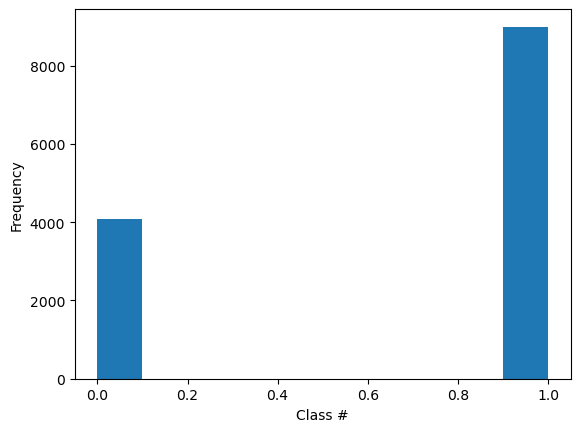

In [23]:
# 0 is non anomily and 1 is anomaly 
data['label'].plot(kind='hist')
plt.xlabel('Class #')

# Run the Sbert.py file to vectorize the data 

In [25]:
# Get embedding of data 
# you can just run SBERT on the data['text'] but i had to by pass it by running the SBERT_embedding.py
# script and load it through here 
vec_data= np.load('./embedding.npy')

# Train test split 
random.seed(4)
train_x,test_x,train_y,test_y= train_test_split(vec_data,data['label'],train_size=.8)

Model creation 

In [27]:
# creating model 
model = OneClassSVM(
    kernel='poly',     # Radial basis function kernel
    gamma=0.1,        # Kernel coefficient
    nu=0.1           # Upper bound on fraction of outliers
)

# Train the model
model.fit(train_x)

# Make predictions
y_pred = model.predict(test_x)

# in this case since non anomaly is the minority ( the model thinks non anomalies is the anomalies ) or in this case the anamoly are the " non anamanious comments"

####### Orig predictions #########
y_pred = np.where(y_pred == -1, 0, 1)  

########### use anomaly scores to get predictions  ###########
anomaly_scores = model.score_samples(test_x) # lower scores more anominous higher scores less
threshold = np.percentile(anomaly_scores, 95)  # 5th percentile as threshold ( captures the lowest scores can lower percitle to capture the most bottomist)
predictions = np.where(anomaly_scores > threshold, 0, 1)  # 1 for normal, -1 for anomalies


# or can use anomaly score directly and find x percent for cutoff  
# Convert scores to probabilities (0 to 1 scale)
normalized_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))
predictions_norm = np.where(normalized_scores > .95, 0, 1) 

# Differnce betweeen model decision and mines
- model.predict uses offset (lower value)
- im using threshold (higher value)

In [28]:
threshold

0.015101291795246104

In [29]:
model.offset_

array([0.00917095])

In [30]:
print(accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.6324035154757356
              precision    recall  f1-score   support

           0       0.33      0.15      0.20       834
           1       0.68      0.86      0.76      1783

    accuracy                           0.63      2617
   macro avg       0.51      0.50      0.48      2617
weighted avg       0.57      0.63      0.58      2617



In [31]:
# Based on 95 percentile
print(accuracy_score(test_y,predictions))
print(classification_report(test_y,predictions))

0.6763469621704241
              precision    recall  f1-score   support

           0       0.45      0.07      0.12       834
           1       0.69      0.96      0.80      1783

    accuracy                           0.68      2617
   macro avg       0.57      0.52      0.46      2617
weighted avg       0.61      0.68      0.59      2617



In [32]:
# Based on  normlization
print(accuracy_score(test_y,predictions_norm))
print(classification_report(test_y,predictions_norm))

0.6820787160871227
              precision    recall  f1-score   support

           0       0.62      0.01      0.01       834
           1       0.68      1.00      0.81      1783

    accuracy                           0.68      2617
   macro avg       0.65      0.50      0.41      2617
weighted avg       0.66      0.68      0.56      2617



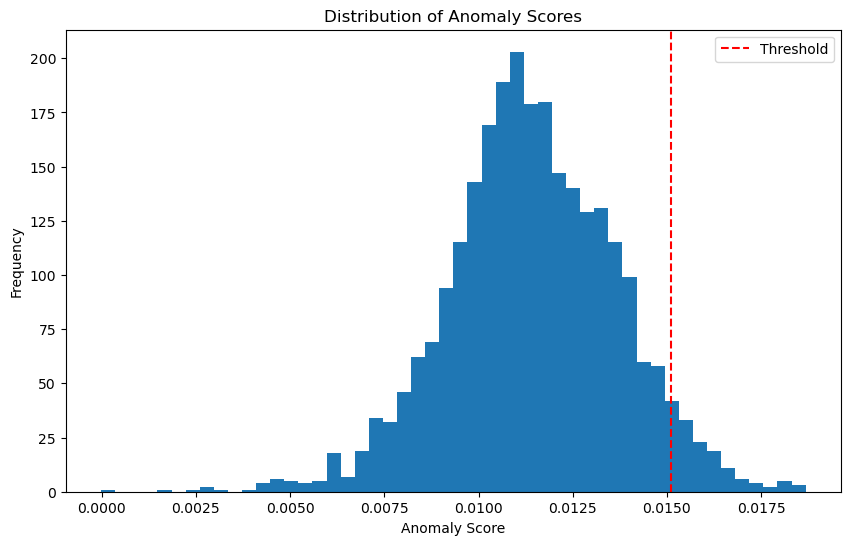

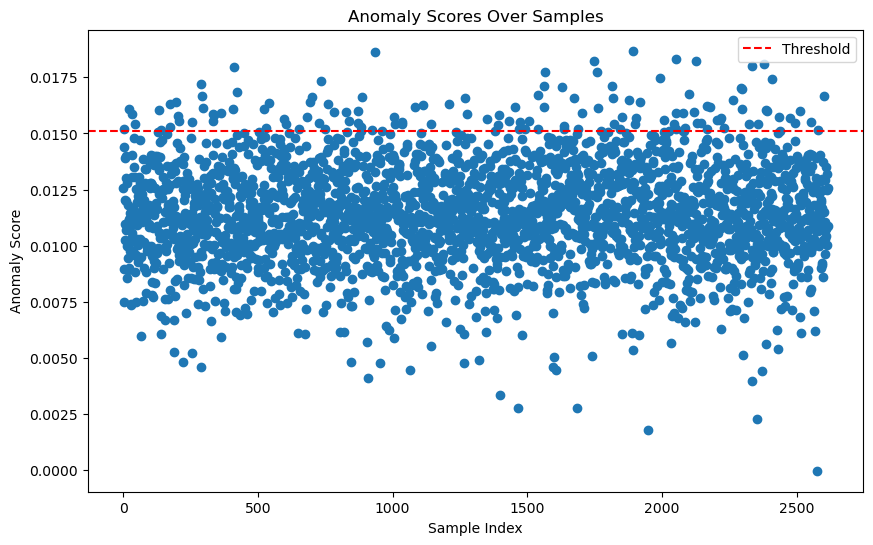

In [41]:
# Plot score distribution
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot scores over time
plt.figure(figsize=(10, 6))
plt.scatter(range(0,len(anomaly_scores)),anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()


# ROC CURVE

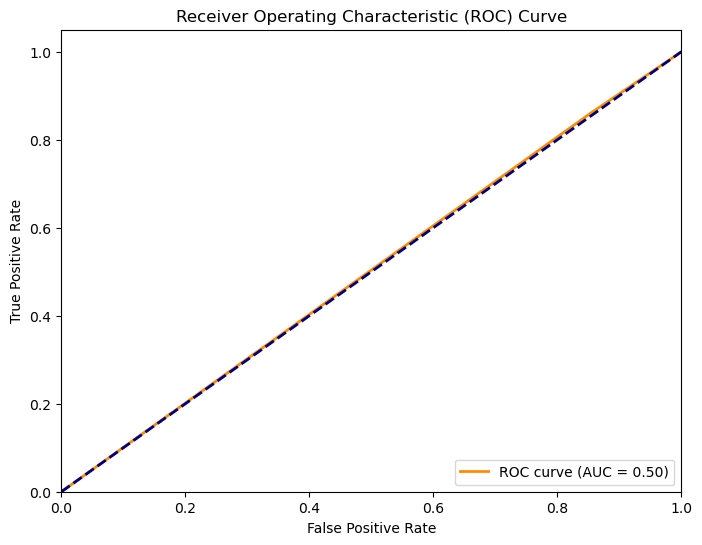

In [38]:
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix

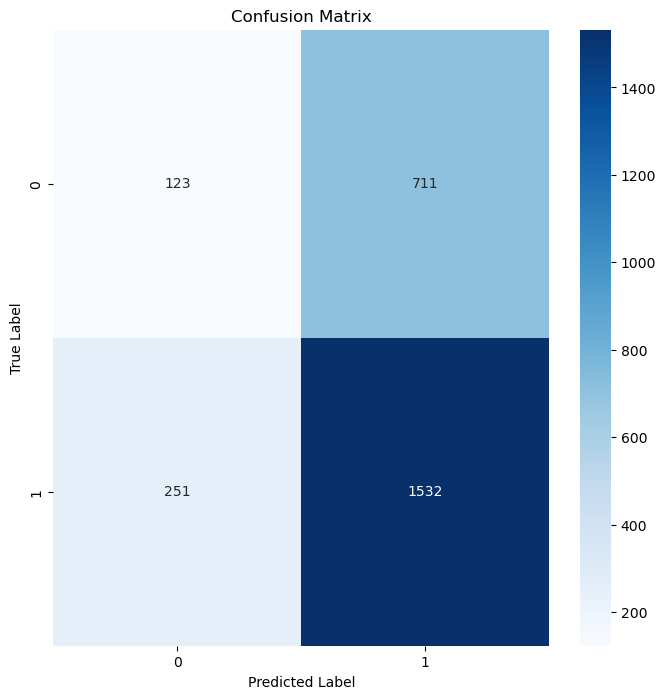

In [39]:
cm = confusion_matrix(test_y, y_pred)

# Create visualization
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Results  
As a result we can see we can currentl see that the model is terrbile. we should go back and revise how we're creating our labels since we have more anomlies than actual normal text which should be the other way around. Also These scores are no better than random guessing   

# TO DO
Try new models from paper

# Next step is try to create the PolyAi NN model 

Try topic modeling for example LDA to choose your anaomalies(look at topics that are anaomalies and see what data points contribute to it ) and make anom or non anaom based on this 

perecision recall curve

change weights if needed because wee need to 100% evade letting fraud pass by
Time series
Link fraudalint score to amount of credit cards and to credit card ( peopel below x credit score have a haigher fraud level)

mcc code doesnt always capture all of the finer merchants 

maybe look into payment network and then use this to make own categories
